Cálculo de Desperdicio de Acero a partir de Modelo de Información BIM Edificación.

#LIBRERÍAS

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#FUNCIÓN DE AGRUPAMIENTO

###Función para Grupos y Diámetros

In [3]:
# Definir función para agrupar longitudes de barra en metros en grupos cercanos a 9 m.

def asignar_grupos(df):
    df = df.copy()
    df["Grupo"] = 0
    grupo_actual = 1

    # Ordenar de mayor a menor por longitud de barra
    df_sorted = df.sort_values(by=["Longitud de barra (m)"], ascending=False).reset_index(drop=True)

    # Variabla para almacenar longitud acumulada del grupo
    suma_actual = 0

    # Lista de índices no asignados
    indices_no_asignados = df_sorted.index.tolist()

    while len(indices_no_asignados) > 0:
        suma_actual = 0
        for i in indices_no_asignados.copy():
            # Si la longitud sumada no excede 9 metros, asignar al grupo
            if suma_actual + df_sorted.at[i, "Longitud de barra (m)"] <= 9:
                df_sorted.at[i, "Grupo"] = grupo_actual
                suma_actual += df_sorted.at[i, "Longitud de barra (m)"]
                indices_no_asignados.remove(i)  # Eliminar índice ya asignado

        grupo_actual += 1  # Incrementar el grupo cuando ya no se pueda agregar más (mayor que 9)

    # Volver a ordenar el dataframe original por su índice
    df = df_sorted.sort_index()

    return df





In [4]:
# Definir función para ejecutar agrupamiento por valores únicos de diámetro

def asignar_grupos_por_diametro(df):

    # Lista de resultados para concatenar después
    dfs_resultados = []

    # Obtener los valores únicos de la columna 'Diámetro'
    for diametro in df['Diámetro'].unique():

        # Filtrar el dataframe para cada valor único de 'Diámetro'
        df_diametro = df[df['Diámetro'] == diametro]

        # Aplicar la función de agrupamiento a dataframe filtrado
        df_diametro_asignado = asignar_grupos(df_diametro)

        # Agregar el dataframe resultante a la lista
        dfs_resultados.append(df_diametro_asignado)

    # Concatenar todos los dataframes resultantes
    df_final = pd.concat(dfs_resultados)

    # Volver a ordenar el dataframe original por su índice
    df_final = df_final.sort_index()

    return df_final





#DESPERDICIO COLUMNAS, PLACAS Y VIGAS

##Carga de Tablas

In [5]:
# Tablas para cálculo de Varillas Comerciales - Modelo con criterios constructivos.
df_col=pd.read_csv('/content/acero columnas lab.csv',sep=";")
df_placas=pd.read_csv('/content/acero placas lab.csv',sep=";")
df_viga=pd.read_csv('/content/acero vigas lab.csv',sep=";")

# Tablas para linea base - Metrado de Presupuesto
dfb_col=pd.read_csv('/content/acero base columnas.csv',sep=";")
dfb_placas=pd.read_csv('/content/acero base placas.csv',sep=";")
dfb_viga=pd.read_csv('/content/acero base vigas.csv',sep=";")

# Tabla auxiliar pesos nominales
df_peso=pd.read_csv('/content/acero pesos.csv',sep=";")


##Preparar Tablas

###Quitar filas en blanco

In [6]:
# Quitar filas en blanco en función de la columna Longitud de barra
df_col=df_col.dropna(subset=['Longitud de barra (m)'])
df_placas=df_placas.dropna(subset=['Longitud de barra (m)'])
df_viga=df_viga.dropna(subset=['Longitud de barra (m)'])

dfb_col=dfb_col.dropna(subset=['Longitud de barra (m)'])
dfb_placas=dfb_placas.dropna(subset=['Longitud de barra (m)'])
dfb_viga=dfb_viga.dropna(subset=['Longitud de barra (m)'])


### Ver Tipos

In [7]:
# Convertir Peso total en número con 5 decimales
dfb_col['Peso total (kg)']=dfb_col['Peso total (kg)'].astype(float)
dfb_placas['Peso total (kg)']=dfb_placas['Peso total (kg)'].astype(float)
dfb_viga['Peso total (kg)']=dfb_viga['Peso total (kg)'].astype(float)

# Ver Tipos
#dfb_col.dtypes
#dfb_placas.dtypes
#dfb_viga.dtypes


###Seleccionar Columnas

In [8]:
# Para el Metrado Base mantener agrupamiento de Elemento, Diámetro Longitud de Barra y Peso
dfb_col=dfb_col[['Elemento','Diámetro','Longitud de barra (m)','Peso total (kg)']]
dfb_placas=dfb_placas[['Elemento','Diámetro','Longitud de barra (m)','Peso total (kg)']]
dfb_viga=dfb_viga[['Elemento','Diámetro','Longitud de barra (m)','Peso total (kg)']]

# Para el Metrado de Cálculo mantenener Elemento, Diámetro, Cantidad, Longitud de Barra
# El peso será calculado despues con una tabla auxiliar
df_col=df_col[['Elemento','Diámetro','Cantidad','Longitud de barra (m)']]
df_placas=df_placas[['Elemento','Diámetro','Cantidad','Longitud de barra (m)']]
df_viga=df_viga[['Elemento','Diámetro','Cantidad','Longitud de barra (m)']]

###Expandir filas de cantidad agrupadas

In [9]:
# Duplicar filas en base a Cantidad (Solo para Metrado de Cálculo no en el Base)
df2_col = df_col.copy()
df2_col = df2_col.loc[df2_col.index.repeat(df2_col['Cantidad'])].reset_index(drop=True)
df2_col = df2_col.drop(columns=['Cantidad'])

df2_placas = df_placas.copy()
df2_placas = df2_placas.loc[df2_placas.index.repeat(df2_placas['Cantidad'])].reset_index(drop=True)
df2_placas = df2_placas.drop(columns=['Cantidad'])

df2_viga = df_viga.copy()
df2_viga = df2_viga.loc[df2_viga.index.repeat(df2_viga['Cantidad'])].reset_index(drop=True)
df2_viga = df2_viga.drop(columns=['Cantidad'])

# Concatenar DataFrames
df_cal=pd.concat([df2_col,df2_placas,df2_viga])
df_bas=pd.concat([dfb_col,dfb_placas,dfb_viga])

# Filtar longitudes menor igual que 9 (Por errores en el modelo BIM) solo para Metrado de Cálculo
df_cal=df_cal[df_cal['Longitud de barra (m)']<=9]

# Ordenar Ascendente
df_cal = df_cal.sort_values(by=['Diámetro','Longitud de barra (m)'],ascending=False)

# Reiniciar Indice
df_cal=df_cal.reset_index(drop=True)
df_bas=df_bas.reset_index(drop=True)



###Revisar Valores Únicos de Diámetro

In [10]:
# Ver valores únicos en df_cal
df_cal['Diámetro'].unique()

# Remplezar 7.1" por 1", 6.3/4" por 3/4" y 3.1/2" por 1/2"
df_cal['Diámetro']=df_cal['Diámetro'].replace(['7.1"','6.3/4"','3.1/2"'],['1"','3/4"','1/2"'])

#df_cal['Diámetro'].unique()

# Ordenar Ascendente
df_cal = df_cal.sort_values(by=['Diámetro','Longitud de barra (m)'],ascending=False)

# Reiniciar Indice
df_cal=df_cal.reset_index(drop=True)

In [11]:
#Ver valores únicos en df_bas
df_bas['Diámetro'].unique()

#Quitar espacios en blanco de valores de Diámetro
df_bas['Diámetro']=df_bas['Diámetro'].str.strip()

#df_bas['Diámetro'].unique()


# Reiniciar Indice
df_bas=df_bas.reset_index(drop=True)




## Aplicar Función de Agrupamiento

In [12]:
# Aplicar función agrupamiento a dataframe df_cal
group_assignments = asignar_grupos_por_diametro(df_cal)

# Agrupar por grupo
df_cal_grupo = group_assignments.groupby(["Grupo", "Diámetro"]).agg({"Longitud de barra (m)": "sum"}).reset_index()

##Calcular Desperdicios

###Calcular Cantidad de Varillas en Kg

In [13]:
#Agregar columna de longitud comercial para cada fila (Cada fila es un grupo)
df_cal_grupo["Longitud Comercial (m)"]=9.0

#Calcular diferencia de longitud de grupo respecto a Varilla Comercial
df_cal_grupo["Dif (m)"]=df_cal_grupo["Longitud Comercial (m)"]-df_cal_grupo["Longitud de barra (m)"]

#Agrupar por Diámetro, suma de Diferencia y Longitud de Varilla Comercial
df_cal_grupo_desperdicio=df_cal_grupo.groupby(['Diámetro']).agg({'Dif (m)': 'sum','Longitud Comercial (m)': 'sum'}).reset_index()

#Agregar columna Elemento y ordenar al inicio
df_cal_grupo_desperdicio["Elemento"]="Placas-Columnas-Vigas"
df_cal_grupo_desperdicio=df_cal_grupo_desperdicio[["Elemento","Diámetro","Dif (m)","Longitud Comercial (m)"]]

#Combinar dataframe con tabla auxiliar de peso
df_cal_grupo_desperdicio=pd.merge(df_cal_grupo_desperdicio,df_peso,on='Diámetro')

#Agregar columna de Peso Comercial (kg)
df_cal_grupo_desperdicio["Peso Comercial (kg)"]=df_cal_grupo_desperdicio["Longitud Comercial (m)"]*df_cal_grupo_desperdicio["Peso de acero"]

df_cal_grupo_desperdicio


,Elemento,Diámetro,Dif (m),Longitud Comercial (m),Peso de acero,Peso Comercial (kg)
0,Placas-Columnas-Vigas,"1""",164.30,2835.0,3.973,11263.455
1,Placas-Columnas-Vigas,"1/2""",19.24,117.0,0.994,116.298
2,Placas-Columnas-Vigas,"1/4""",10.24,108.0,0.222,23.976
3,Placas-Columnas-Vigas,"3/4""",290.48,4257.0,2.235,9514.395
4,Placas-Columnas-Vigas,"3/8""",941.12,19080.0,0.560,10684.800
5,Placas-Columnas-Vigas,"5/8""",79.90,225.0,1.552,349.200


###Calcular Cantidad de Acero en Metrado Base

In [14]:
# Agrupar df_base por Diámetro
df_bas_grupo = df_bas.groupby(["Diámetro"]).agg({"Peso total (kg)": "sum"}).reset_index()

# Cambiar nombre de columna Peso Total (kg)
df_bas_grupo = df_bas_grupo.rename(columns={"Peso total (kg)": "Peso Base (kg)"})

df_bas_grupo


,Diámetro,Peso Base (kg)
0,"1""",7699.077287
1,"1/2""",96.927142
2,"1/4""",21.755592
3,"3/4""",8514.902722
4,"3/8""",10006.004125
5,"5/8""",242.954671


###Calcular Desperdicio con Metrado Base

In [15]:
# Combinar dataframe de cálculo con dataframe base
df_desperdicio=pd.merge(df_cal_grupo_desperdicio,df_bas_grupo,on='Diámetro')

# Agregar columna de desperdicio
df_desperdicio["Desperdicio (kg)"]=df_desperdicio["Peso Comercial (kg)"]-df_desperdicio["Peso Base (kg)"]

# Agregar columna de desperdicio porcentual
df_desperdicio["Desperdicio (%)"]=df_desperdicio["Desperdicio (kg)"]/df_desperdicio["Peso Base (kg)"]*100

df_desperdicio

,Elemento,Diámetro,Dif (m),Longitud Comercial (m),Peso de acero,Peso Comercial (kg),Peso Base (kg),Desperdicio (kg),Desperdicio (%)
0,Placas-Columnas-Vigas,"1""",164.30,2835.0,3.973,11263.455,7699.077287,3564.377713,46.296167
1,Placas-Columnas-Vigas,"1/2""",19.24,117.0,0.994,116.298,96.927142,19.370858,19.984968
2,Placas-Columnas-Vigas,"1/4""",10.24,108.0,0.222,23.976,21.755592,2.220408,10.206148
3,Placas-Columnas-Vigas,"3/4""",290.48,4257.0,2.235,9514.395,8514.902722,999.492278,11.738153
4,Placas-Columnas-Vigas,"3/8""",941.12,19080.0,0.560,10684.800,10006.004125,678.795875,6.783886
5,Placas-Columnas-Vigas,"5/8""",79.90,225.0,1.552,349.200,242.954671,106.245329,43.730515


In [16]:
df_desperdicio_total=df_desperdicio.groupby(['Elemento']).agg({'Desperdicio (kg)': 'sum','Peso Base (kg)': 'sum'}).reset_index()
df_desperdicio_total["Desperdicio (%)"]=df_desperdicio_total["Desperdicio (kg)"]/df_desperdicio_total["Peso Base (kg)"]*100
df_desperdicio_total


,Elemento,Desperdicio (kg),Peso Base (kg),Desperdicio (%)
0,Placas-Columnas-Vigas,5370.502461,26581.621539,20.203818


## Ver Resultados

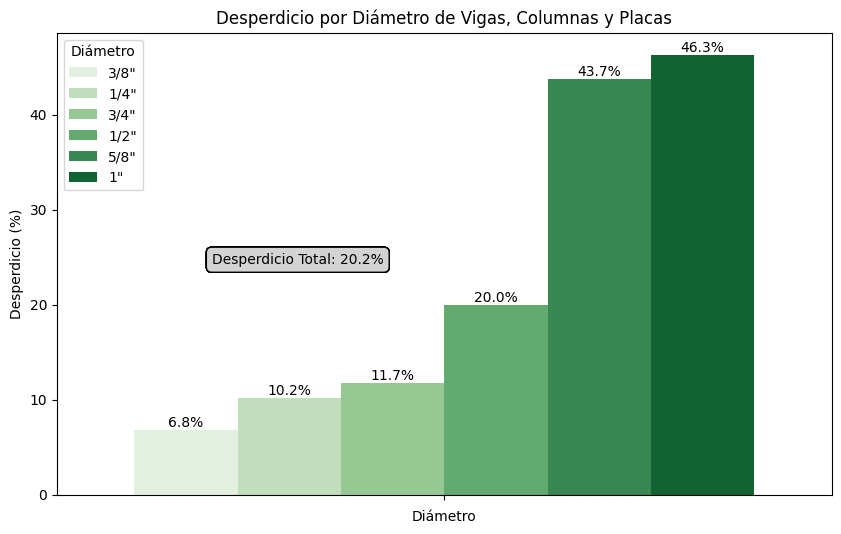

In [69]:
# Gráfica de desperdicio por diámetro de mayor menor desperdicio porcentual con seaborn
# Definir Figura
plt.figure(figsize=(10, 6))

# Gráfica de barras
ax=sns.barplot(
    hue='Diámetro', y='Desperdicio (%)',
    data=df_desperdicio.sort_values(by='Desperdicio (%)', ascending=True),
    palette="Greens")

# Nombre de ejes y Título
plt.title('Desperdicio por Diámetro de Vigas, Columnas y Placas')
plt.xlabel('Diámetro')
plt.ylabel('Desperdicio (%)')

# Agregar etiquetas de datos con formato
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

    # Agregar tarjeta de datos con valor de Desperdicio % total
    plt.annotate(
    f"Desperdicio Total: {df_desperdicio_total['Desperdicio (%)'].max():.1f}%",
    xy=(0.2, 0.5),
    xycoords='axes fraction',
    bbox=dict(boxstyle="round,pad=0.4", edgecolor="Black", facecolor="lightgray"))

plt.show()
